 Amazon üzerinden satışlarını gerçekleştiren ev tekstili ve günlük giyim odaklı üretimler yapan Kozmos, ürünlerine gelen yorumları analiz ederek ve aldığı şikayetlere göre özelliklerini geliştirerek satışlarını artırmayı hedeflemektedir. Bu hedef doğrultusunda yorumlara duygu analizi yapılarak etiketlenecek ve etiketlenen veri ile sınıflandırma (logistic regresyon ve random forest) modelleri oluşturulmuştur.

In [17]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [18]:
filterwarnings ('ignore') # bazı warningleri ignore etme 
pd.set_option('display.max_columns', None)   # bütün sütunları göster 
pd.set_option('display.width', 200)   # max genişlik ayarı
pd.set_option('display.float_format', lambda x: '%.2f' % x) # virgülden sonra iki basamak göster

In [19]:
! pip install openpyxl

In [20]:
df = pd.read_excel("amazon.xlsx") # veri setini okuma

In [21]:
df

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...
...,...,...,...,...
5606,4,0,Recommend,Great product for reasonable money. Delivered...
5607,5,0,"Terrible , different colors. I returned",Color is way off and panels do not match
5608,5,0,Extremely pleasing,These are great for my studio as they compleme...
5609,5,0,Perfect,Brought out the beauty in kids room. They love...


Star : yıldız sayısını
HelpFul: yapılan yorumu kaç kişinin faydalı bulduğu
Title : yorum başlıkları
Review : yapılan yorumları
ifade eder

# METİN ÖN İŞLEME

In [22]:
# Bütün harfleri küçük harfe çevirme 

# Normalizing Case Folding
###

df ['Review'] = df['Review'].str.lower()
df['Review']

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windows.<br />imag...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i can't believe the qu...
                              ...                        
5606    great product for reasonable money.  delivered...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609    brought out the beauty in kids room. they love...
5610    very cute curtains in my sons room! thick enou...
Name: Review, Length: 5611, dtype: object

In [23]:
# Noktalamaişaretlerini çıkarma
import re 
df['Review'] = df['Review'].apply(lambda x: re.sub("[^\w\s]","", str(x)))
df['Review']

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

In [24]:
# Yorumlarda bulunan sayısal ifadeleri çıkarma
df['Review'] = df['Review'].fillna('').apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
df['Review']

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

In [25]:
# Bilgi içermeyen kelimeleri (stopwords) veriden çıkarma
import nltk 
nltk.download('stopwords') 

sw = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df['Review']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\havva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                                                   happy
1         good quality material however panels mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria es que sean un poco mas ...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme studioliv...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

In [26]:
# 1000'den az geçen kelimeleri veriden çıkarma
temp_df = pd.Series(' '.join(df['Review']).split()).value_counts() # bütün kelimleri saydırıyoruz ve geçici dataframe aktarıyoruz
temp_df

drops = temp_df[temp_df < 100] # 100den az frekanslıları seçip dropsa atıyoruz
drops

df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))
df['Review']

0                                            happy
1                     good quality material panels
2         product bedroom bit still material sheer
3                                                 
4       great cant quality material vibrant colors
                           ...                    
5606                 great product money recommend
5607                              color way panels
5608              great photo product good quality
5609                                     room love
5610              curtains room thick enough light
Name: Review, Length: 5611, dtype: object

In [27]:
# TOKENIZATION # cümleleri tokenlarına ayırma yani parçalama, birimleştirme işlemini programatik hale getirmek 

nltk.download("punkt")
df["Review"].apply(lambda x: TextBlob(x).words).head() # TextBlob metodu çalıştıırıldıktan sonra kelimeler gelsin 

# LEMMATIZATION işlemini gerçekleştirme
nltk.download('wordnet')
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) # bütün kelimeleri köklerine ayırır
df['Review']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\havva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\havva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                                           happy
1                     good quality material panel
2        product bedroom bit still material sheer
3                                                
4       great cant quality material vibrant color
                          ...                    
5606                great product money recommend
5607                              color way panel
5608             great photo product good quality
5609                                    room love
5610              curtain room thick enough light
Name: Review, Length: 5611, dtype: object

# METİN GÖRSELLEŞTİRME

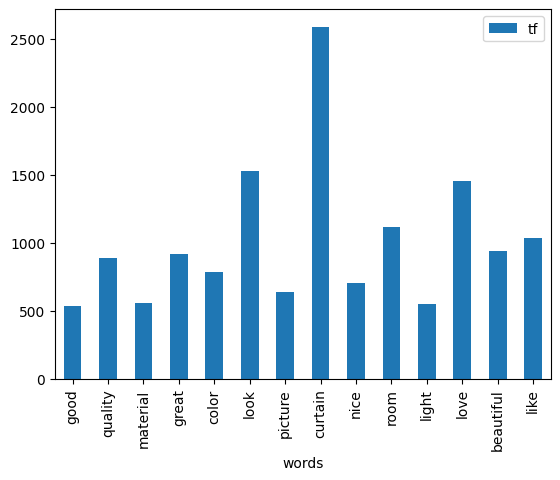

In [29]:
# Barplot Görselleştirme 
tf = df['Review'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"] # sütun başlıkları ekleme 
tf.sort_values("tf", ascending=False) # büyükten küçüğe sıralandı
tf[tf["tf"] > 500].plot.bar(x="words", y="tf") # frekansı 500'den büyük kelimelerin sütun grafiği çizilir
plt.show()


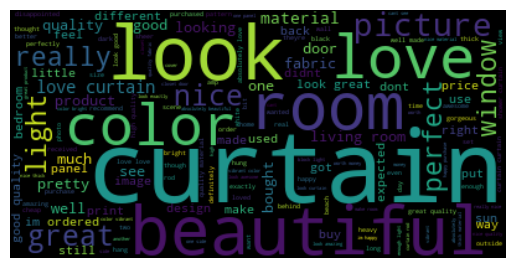

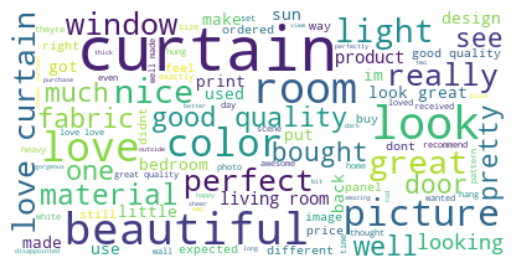

In [31]:
# WordCloud Görselleştirme
text = " ".join(i for i in df.Review)
text
wordCloud = WordCloud().generate(text)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud = WordCloud(max_font_size=50,max_words=100,background_color="white").generate (text)
plt.figure()
plt.imshow (wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# DUYGU ANALİZİ

In [32]:
# SentimentIntensityAnalyzer nesnesini oluşturma
nltk.download("vader_lexicon")  # Sentiment Analizi için kullanılan pre-trained bir model 
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\havva\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:
# SentimentIntensityAnalyzer nesnesi ile polarite puanlarını inceleme
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)) # 10 tane cümlenin duygu skorlarını inceleme

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...
2    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
4    {'neg': 0.255, 'neu': 0.368, 'pos': 0.377, 'co...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.549, 'pos': 0.451, 'comp...
7    {'neg': 0.0, 'neu': 0.595, 'pos': 0.405, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.651, 'pos': 0.349, 'comp...
Name: Review, dtype: object

In [40]:
df["Review"].apply(lambda x: sia.polarity_scores(x)['compound']) # 'compound' skorlarına göre filtreleyerek tekrar inceleme

0      0.57
1      0.44
2      0.00
3      0.00
4      0.32
       ... 
5606   0.77
5607   0.00
5608   0.79
5609   0.64
5610   0.00
Name: Review, Length: 5611, dtype: float64

In [41]:
# "Review" değişkenindeki tüm gözlemler için pos-neg atamasını yaparak yeni bir değişken olarak dataframe'e ekleme
df["sentiment_label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores (x) ["compound"]> 0 else "neg")
df["sentiment_label"].value_counts()

# SentimentIntensityAnalyzer ile yorumları etiketleyerek, yorum sınıflandırma makine öğrenmesi modeli için bağımlı değişken oluşturulmuş oldu.

sentiment_label
pos    4409
neg    1202
Name: count, dtype: int64

In [44]:
df

,Star,HelpFul,Title,Review,sentiment_label
0,5,0,looks great,happy,pos
1,5,0,Pattern did not align between the two panels.,good quality material panel,pos
2,5,0,Imagery is stretched. Still fun.,product bedroom bit still material sheer,neg
3,5,0,Que se ven elegantes muy finas,,neg
4,5,0,Wow great purchase,great cant quality material vibrant color,pos
...,...,...,...,...,...
5606,4,0,Recommend,great product money recommend,pos
5607,5,0,"Terrible , different colors. I returned",color way panel,neg
5608,5,0,Extremely pleasing,great photo product good quality,pos
5609,5,0,Perfect,room love,pos


In [45]:
df ["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"]) # makine öğrenimi modellerinin daha iyi anlayabilmesi için 0-1 e dönüştürme 
df

,Star,HelpFul,Title,Review,sentiment_label
0,5,0,looks great,happy,1
1,5,0,Pattern did not align between the two panels.,good quality material panel,1
2,5,0,Imagery is stretched. Still fun.,product bedroom bit still material sheer,0
3,5,0,Que se ven elegantes muy finas,,0
4,5,0,Wow great purchase,great cant quality material vibrant color,1
...,...,...,...,...,...
5606,4,0,Recommend,great product money recommend,1
5607,5,0,"Terrible , different colors. I returned",color way panel,0
5608,5,0,Extremely pleasing,great photo product good quality,1
5609,5,0,Perfect,room love,1


# MAKİNE ÖĞRENMESİNE HAZIRLIK

In [46]:
# Bağımlı ve bağımsız değişkenlerimizi belirleyerek datayı train test olarak ayırınız.
y = df["sentiment_label"] # bağımlı değişken 
x = df["Review"]   # bağımsız değişken 

In [63]:
# Makineöğrenmesimodeline verileri verebilmemiz için temsil şekillerini sayısala çevirme

from sklearn.feature_extraction.text import TfidfVectorizer
# word
tf_idf_word_vectorizer = TfidfVectorizer() # TfidfVectorizer kullanarak bir nesne oluşturma
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(x) # Daha önce ayırmış olan train datasını kullanarak oluşturulan nesneye fit etme
print(tf_idf_word_vectorizer.get_feature_names_out()[10:15]) # bazı eşsiz kelimeler

# ngram
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(x)
#print("X_tf_idf_ngram: " , X_tf_idf_ngram)
print(tf_idf_ngram_vectorizer.get_feature_names_out()[10:15]) # bazı eşsiz kelime öbekleri

['behind' 'better' 'bit' 'black' 'block']
['absolutely beautiful bought' 'absolutely beautiful color'
 'absolutely beautiful could' 'absolutely beautiful curtain'
 'absolutely beautiful dont']


# MODELLEME 

* LOJISTIC REGRESYON

In [49]:
# Lojistik regresyon modelini kurarak train dataları ile fit etmw
log_model = LogisticRegression().fit(X_tf_idf_word, y)

In [50]:
# Cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplama
cross_val_score(log_model, X_tf_idf_word, y, scoring="accuracy", cv=5).mean() # 5 katlı çapraz doğrulama 

0.9764751913879774

In [51]:
# Kurmuş olunan model ile tahmin işlemleri gerçekleştirme
new_review = pd.Series("This product is great")  # bunu bağımsız değişkenlerle aynı formata getirmek lazım
new_review = TfidfVectorizer().fit(x).transform(new_review) # TF-IDF Vectorizerden bu veri geçirilmeli 
log_model.predict(new_review) # yorum pozitif mi negatif mi tahmin ettiriyoruz / array([1]) => pozitif  

array([1])

In [55]:
# Veride bulunan yorumlardan rastgele seçerek modele sorulması
random_review = pd.Series(df["Review"].sample(5).values)  # df["reviewText"]'ten random olarak 5 örnek alınır ve etiketi tahmin ettirilir
print(random_review)
random_review = TfidfVectorizer().fit(x).transform(random_review)
log_model.predict(random_review) 

0          used beautiful thought made curtain ordered
1                                            beautiful
2                        pretty quality look good good
3                                                     
4    amp used curtain scene amp room amp picture wo...
dtype: object


array([1, 1, 1, 0, 1])

In [ ]:
# Modeli dosyaya kaydetme
import joblib
model_path = 'model.pkl'
# joblib.dump(log_model, model_path)

* RANDOM FOREST

In [56]:
#  RandomForestClassifier modelini kurup fit etme
rf_model_tfidfword = RandomForestClassifier().fit(X_tf_idf_word, y)

In [57]:
# Cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplama
cross_val_score(rf_model_tfidfword, X_tf_idf_word, y, scoring="accuracy", cv=5, n_jobs=-1).mean()

0.9830700806186636

In [58]:
new_review2 = pd.Series("This product is great")
new_review2 = TfidfVectorizer().fit(x).transform(new_review2)
rf_model_tfidfword.predict(new_review2)

array([1])